# Demo

In [1]:
import sys

sys.path.append("../src")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import sys
import os
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


%load_ext autoreload
%autoreload 2

### Dataset
We'll use the Iris dataset from sklearn. This dataset has three classes.

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
print(df.isnull().sum())
df["class"] = y

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.DataFrame(X_train, columns=feature_names)
val_df = pd.DataFrame(X_val, columns=feature_names)

numerical_features = feature_names
categorical_features = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


### Define Logistic Regression Model
We'll define a multiclass Logistic Regression model using PyTorch. The model will have a linear layer that maps the input features to the class scores.

In [4]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

### Define Loss

In [5]:
class LogisticRegressionLoss(nn.Module):
    def __init__(self, model, lambd):
        super(LogisticRegressionLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.model = model
        self.lambd = lambd

    def forward(self, outputs, labels):
        # Compute the cross-entropy loss
        ce_loss = self.cross_entropy(outputs, labels)

        # Compute the L2 regularization term
        l2_reg = 0.0
        for param in self.model.parameters():
            l2_reg += torch.norm(param) ** 2

        # Combine the cross-entropy loss and the L2 regularization term
        loss = ce_loss + self.lambd * l2_reg
        return loss

### HyperOptimizer

In [6]:
class HyperTrainer:
    def __init__(self, num_epochs, model, criterion, train_loader, hyper_optimizer):
        self.num_epochs = num_epochs
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.hyper_optimizer = hyper_optimizer
        self.hyperparams_history = {
            name: [hyperparam.item()]
            for name, hyperparam in self.hyper_optimizer.hyperparams.items()
        }

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            for inputs, labels in self.train_loader:

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward(retain_graph=True)

                # Use the hyper optimizer step method
                self.hyper_optimizer.step(loss)
                if self.hyper_optimizer.step_count % self.hyper_optimizer.inner_steps == 0:
                    for name, hyperparam in self.hyper_optimizer.hyperparams.items():
                        self.hyperparams_history[name].append(hyperparam.item())

                # Zero the gradients using the hyper optimizer
                self.hyper_optimizer.zero_grad()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{self.num_epochs}, Training Loss: {running_loss/len(self.train_loader)}")

In [7]:
from hippotrainer import Direct

Epoch 1/10, Training Loss: 2.2428341786066692
Epoch 2/10, Training Loss: 1.0986541350682577
Epoch 3/10, Training Loss: 1.0627401848634084
Epoch 4/10, Training Loss: 1.0694574733575186
Epoch 5/10, Training Loss: 1.0614956001440683
Epoch 6/10, Training Loss: 1.0467563192049663
Epoch 7/10, Training Loss: 1.049116430679957
Epoch 8/10, Training Loss: 1.0572328766187031
Epoch 9/10, Training Loss: 1.054870104789734
Epoch 10/10, Training Loss: 1.0526477515697479
Final Validation Loss: 1.1052


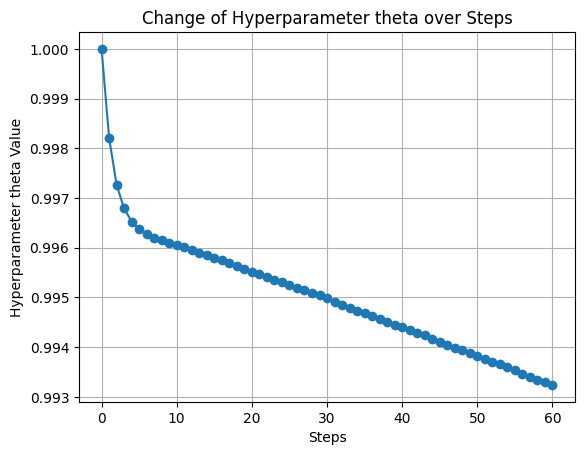

In [8]:
# Usage example
input_dim = len(feature_names)
num_classes = len(class_names)
model = LogisticRegressionModel(input_dim, num_classes)
num_epochs = 10
theta = torch.tensor([1.0], requires_grad=True)
lambd = theta.exp()

# Initialize the custom loss function
criterion = LogisticRegressionLoss(model, lambd)

# Initialize the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize the hyper optimizer
hyper_optimizer = Direct(
    hyperparams={"theta": theta},
    hyper_lr=1e-3,
    inner_steps=5,
    model=model,
    optimizer=optimizer,
    val_loader=val_loader,
    criterion=criterion,
)

# Initialize the trainer
trainer = HyperTrainer(num_epochs, model, criterion, train_loader, hyper_optimizer)

# Train the model
trainer.train()

# Evaluate the model
final_val_loss = hyper_optimizer.evaluate()
print(f"Final Validation Loss: {final_val_loss.item():.4f}")

# Plot the hyperparameter changing
for name, hyperparam_values in trainer.hyperparams_history.items():
    steps = list(range(len(hyperparam_values)))
    plt.plot(steps, hyperparam_values, marker="o")
    plt.xlabel("Steps")
    plt.ylabel(f"Hyperparameter {name} Value")
    plt.title(f"Change of Hyperparameter {name} over Steps")
    plt.grid(True)
    plt.show()

### Neumann (Optimizing Millions of Hyperparameters by Implicit Diﬀerentiation)

In [9]:
# from hippotrainer import Neumann

In [10]:
# torch.autograd.set_detect_anomaly(True)

# # Usage example
# input_dim = len(feature_names)
# num_classes = len(class_names)
# model = LogisticRegaressionModel(input_dim, num_classes)
# num_epochs = 10
# # theta = torch.tensor([1.0], requires_grad=True)
# # lambd = theta.exp()
# lambd = torch.tensor([1.0])

# # Initialize the custom loss function
# criterion = LogisticRegressionLoss(model, lambd)

# # Initialize the optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Initialize the hyper optimizer
# hyper_optimizer = Neumann(
#     hyperparams={"theta": theta},
#     hyper_lr=1e-3,
#     inner_steps=5,
#     model=model,
#     optimizer=optimizer,
#     val_loader=val_loader,
#     criterion=criterion,
# )

# # Initialize the trainer
# trainer = HyperTrainer(num_epochs, model, criterion, train_loader, hyper_optimizer)

# # Train the model
# torch.autograd.set_detect_anomaly(True)
# trainer.train()

# # Evaluate the model
# final_val_loss = hyper_optimizer.evaluate()
# print(f"Final Validation Loss: {final_val_loss.item():.4f}")

# # Plot the hyperparameter changing
# for name, hyperparam_values in trainer.hyperparams_history.items():
#     steps = list(range(len(hyperparam_values)))
#     plt.plot(steps, hyperparam_values, marker="o")
#     plt.xlabel("Steps")
#     plt.ylabel(f"Hyperparameter {name} Value")
#     plt.title(f"Change of Hyperparameter {name} over Steps")
#     plt.grid(True)
#     plt.show()